In [56]:
#!pip install numpy pandas matplotlib scikit-learn tensorflow keras

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import os

ImportError: cannot import name 'current_year_accuracy' from 'sklearn.metrics' (C:\Users\scomp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\__init__.py)

## Carregando os dados e colocando a coluna 'Date' como índice

In [40]:
caminho_pasta = 'Base_dados'
lista_arquivos = [arquivo for arquivo in os.listdir(caminho_pasta) if os.path.isfile(os.path.join(caminho_pasta, arquivo))]

for arq in lista_arquivos:
    #converte a coluna 'Date' para o tipo datetime
    df = pd.read_csv(f'Base_dados/{arq}', parse_dates=['Date'])
    df = df.sort_values('Date')
    # Verificar se a coluna 'Date' existe e definir como índice
    # if 'Date' in df.columns:
    #     df = df.set_index('Date')
    print(df.head())


        Date    Open       High        Low      Close  Adj Close      Volume  \
0 2020-01-29  25.500  25.690001  24.680000  24.730000  18.055990  16800400.0   
1 2020-01-30  24.350  24.995001  24.184999  24.900000  18.180117  25079800.0   
2 2020-01-31  24.555  24.559999  24.110001  24.270000  17.720137  32252800.0   
3 2020-02-03  24.275  24.570000  24.004999  24.389999  17.807749  20402800.0   
4 2020-02-04  24.645  24.799999  24.125000  24.125000  17.614269  23533200.0   

    SMA_10     EMA_10     RSI_10      MACD  MACD_Histogram  BBL_20_2.0  \
0  24.9610  25.132101  40.316762 -0.407259        0.043456   23.842415   
1  24.9785  25.089901  43.272728 -0.397243        0.042777   23.898938   
2  24.8995  24.940828  35.942692 -0.435126        0.003916   23.906795   
3  24.8485  24.840677  38.159656 -0.450275       -0.008986   23.925546   
4  24.8430  24.710554  35.172752 -0.478152       -0.029490   23.906871   

   BBM_20_2.0  BBU_20_2.0  BBB_20_2.0  BBP_20_2.0   ATRr_14    stoch_k  \


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174 entries, 0 to 1173
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            1174 non-null   datetime64[ns]
 1   Open            1174 non-null   float64       
 2   High            1174 non-null   float64       
 3   Low             1174 non-null   float64       
 4   Close           1174 non-null   float64       
 5   Adj Close       1174 non-null   float64       
 6   Volume          1174 non-null   float64       
 7   SMA_10          1174 non-null   float64       
 8   EMA_10          1174 non-null   float64       
 9   RSI_10          1174 non-null   float64       
 10  MACD            1174 non-null   float64       
 11  MACD_Histogram  1174 non-null   float64       
 12  BBL_20_2.0      1174 non-null   float64       
 13  BBM_20_2.0      1174 non-null   float64       
 14  BBU_20_2.0      1174 non-null   float64       
 15  BBB_

# 1 - Pré-Processamento dos Dados

## 1.1 - Selecionar Colunas Relevantes

In [42]:
#hist_TSLA
data = df['Close'].values

## 1.2 - Criação de Variável Alvo (Classificação)
Como você mencionou métricas como acurácia, falso negativo e F1-score, que são usadas em problemas de classificação, vamos converter o problema em uma tarefa de classificação binária (por exemplo, prever se o preço da ação vai subir ou descer no próximo dia).

In [43]:
df['Target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

## 1.3 - Seleção de Recursos (Features)

In [44]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']
X = df[features].values
y = df['Target'].values

## 1.4 - Normalização dos Dados

In [45]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 2 - Criação de Sequências para Treinamento

In [46]:
# Defina o tamanho da janela de tempo (por exemplo, 60 dias):
window_size = 60

# Criando sequências de dados
X_sequences = []
y_sequences = []

for i in range(len(X_scaled) - window_size):
    X_sequences.append(X_scaled[i:i+window_size])
    y_sequences.append(y[i+window_size])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)



# 3 - Redimensionamento dos Dados

In [47]:
# Redimensionando X para 3 dimensões (necessário para Conv1D)
X = np.expand_dims(X, axis=2)

# 4 - Divisão dos Dados em Treino e Teste

## 4.1 Dividindo os Dados

In [48]:
split = int(0.7 * len(X_sequences))
X_train, X_test = X_sequences[:split], X_sequences[split:]
y_train, y_test = y_sequences[:split], y_sequences[split:]

# 5 - Construção do Modelo CNN

In [49]:
model = Sequential()

## 5.1 - Adicionando Camadas ao Modelo

In [50]:
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

## 5.2 - Compilando Modelo

In [51]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 6 - Treinamento do Modelo

In [52]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
25/25 [==============================] - 1s 13ms/step - loss: 0.7043 - accuracy: 0.5186 - val_loss: 0.6969 - val_accuracy: 0.5224
Epoch 2/50
25/25 [==============================] - 0s 5ms/step - loss: 0.6977 - accuracy: 0.5225 - val_loss: 0.6982 - val_accuracy: 0.5224
Epoch 3/50
25/25 [==============================] - 0s 5ms/step - loss: 0.6912 - accuracy: 0.5456 - val_loss: 0.6926 - val_accuracy: 0.4925
Epoch 4/50
25/25 [==============================] - 0s 5ms/step - loss: 0.6947 - accuracy: 0.5148 - val_loss: 0.6929 - val_accuracy: 0.5224
Epoch 5/50
25/25 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5148 - val_loss: 0.6937 - val_accuracy: 0.5224
Epoch 6/50
25/25 [==============================] - 0s 5ms/step - loss: 0.6901 - accuracy: 0.5186 - val_loss: 0.6928 - val_accuracy: 0.4925
Epoch 7/50
25/25 [==============================] - 0s 5ms/step - loss: 0.6889 - accuracy: 0.5379 - val_loss: 0.6922 - val_accuracy: 0.5224
Epoch 8/50
25/25 [=

# 7 - Avaliação do Modelo

In [53]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Métricas de Desempenho
print("Acurácia no teste:", accuracy_score(y_test, y_pred))
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

11/11 [==============================] - 0s 2ms/step
Acurácia no teste: 0.46865671641791046
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.40      0.22      0.28       160
           1       0.49      0.70      0.58       175

    accuracy                           0.47       335
   macro avg       0.45      0.46      0.43       335
weighted avg       0.45      0.47      0.44       335

Matriz de Confusão:
[[ 35 125]
 [ 53 122]]


# 9 - Visualização dos Resultados

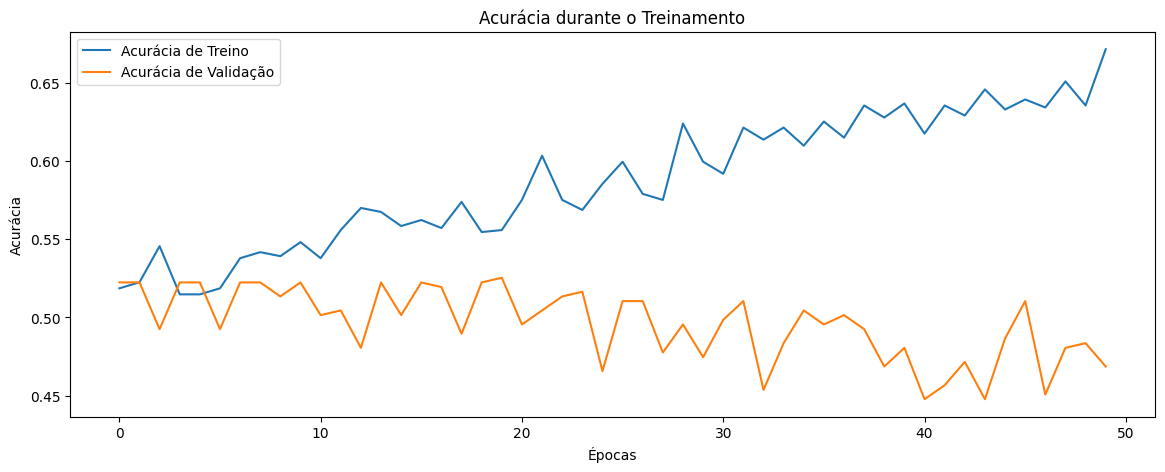

In [54]:
plt.figure(figsize=(14,5))
plt.plot(history.history['accuracy'], label='Acurácia de Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

# 10 - Análise Estatística ao Longo dos Anos

## 10.1 - Preparar dados para Múltiplos Anos:

Vamos dividir os dados por ano e treinar/testar o modelo para cada ano, coletando as métricas de desempenho para calcular a média e o desvio padrão.

In [55]:
years = df['Date'].dt.year.unique()
accuracies = []

for year in years:
    # Filtrar dados do ano
    df_year = df[df['Date'].dt.year == year]
    # (Repetir os passos de preparação, treinamento e avaliação para cada ano)
    # Armazenar a acurácia do ano atual
    accuracies.append(current_year_accuracy)

NameError: name 'current_year_accuracy' is not defined

## 10.2 - Calcular Média e Desvio Padrão da Acurácia

In [ ]:
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
print(f'Acurácia Média: {mean_accuracy}')
print(f'Desvio Padrão da Acurácia: {std_accuracy}')

# 11 - Testar Diversos Modelos
Variar arquiteturas de modelos:

- Alterar o número de camadas convolucionais.
- Modificar o tamanho do kernel e o número de filtros.
- Testar diferentes funções de ativação e otimizadores.
- Comparar com outros modelos (por exemplo, LSTM, modelos baseados em ARIMA)

## 11.1 - Comparar Métricas de Desempenho

In [ ]:
# Armazenar métricas de cada modelo
model_results = {
    'Modelo 1': {'acurácia': acc1, 'precisão': prec1},
    'Modelo 2': {'acurácia': acc2, 'precisão': prec2},
    # ...
}

# Calcular desvio padrão das métricas
accuracies = [result['acurácia'] for result in model_results.values()]
precisions = [result['precisão'] for result in model_results.values()]

mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)
mean_prec = np.mean(precisions)
std_prec = np.std(precisions)

print(f'Acurácia Média entre Modelos: {mean_acc}, Desvio Padrão: {std_acc}')
print(f'Precisão Média entre Modelos: {mean_prec}, Desvio Padrão: {std_prec}')

15. Documentação e Análise Final

Documente cada modelo testado:
- Arquitetura do modelo.
- Hiperparâmetros utilizados.
- Métricas de desempenho obtidas.

Análise Comparativa:
- Identifique qual modelo apresentou o melhor desempenho.
- Discuta possíveis razões para as diferenças observadas.
- Considere o trade-off entre complexidade do modelo e desempenho.

Conclusões:
- Apresente insights sobre a previsibilidade dos preços das ações com base nos modelos testados.
- Destaque as limitações encontradas e sugira possíveis melhorias para trabalhos futuros.


Considerações Especiais
Manutenção da Ordem Temporal:

- É crucial não embaralhar os dados, pois a sequência temporal influencia diretamente nas previsões financeiras.

Avaliação Apropriada de Métricas:
- Para problemas de classificação binária em séries temporais financeiras, além de acurácia, considere utilizar métricas como ROC AUC, F1-score, precisão e revocação.

Validação Cruzada em Séries Temporais:
- Utilize técnicas de validação cruzada específicas para séries temporais, como TimeSeriesSplit do Scikit-learn.

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X_sequences):
    X_train, X_test = X_sequences[train_index], X_sequences[test_index]
    y_train, y_test = y_sequences[train_index], y_sequences[test_index]
    # Treinar e avaliar o modelo

Análise de Desempenho ao Longo do Tempo:
- Verifique se o desempenho do modelo se mantém consistente ao longo dos anos ou se há variabilidade significativa.

Consideração de Fatores Externos:
- Considere incorporar indicadores técnicos ou dados macroeconômicos que possam afetar os preços das ações.

Dicas Finais

Registrar Todos os Resultados:
- Mantenha um registro detalhado dos resultados de cada modelo e configuração testada para facilitar a análise comparativa.

Reprodutibilidade:
- Assegure-se de que todo o código e procedimentos sejam reprodutíveis, permitindo que outros validem e construam sobre o seu trabalho.

Discussão Crítica:
- Analise não apenas os resultados positivos, mas também as limitações e desafios enfrentados durante o projeto.